In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from artcv.model import ArtCV
from artcv.trainer import Trainer
from artcv.datatool import ImgDataset, TrainValSet
import sys
torch.cuda.is_available()

True

In [2]:
model = ArtCV(classifier_layers=(1, 1, 1, 1, 1), dropout_rate=0)
model

ArtCV(
  (cnn): ResNet_CNN(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [3]:
indices = [i for i in range(0, 2096)]
#indices = None
dataset = TrainValSet(indices=indices)

In [3]:
model = ArtCV()
file_name = '04302020_resnet18_1layer.model.pkl'
save_path = f'{sys.path[0]}/weights/{file_name}'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [4]:
trainer = Trainer(model, dataset, batch_size_train=32, batch_size_val=32, batch_size_all=128,
                  dataloader_train_kwargs={'num_workers':4}, dataloader_val_kwargs={'num_workers':4},
                 dataloader_all_kwargs={'num_workers':4})

In [5]:
trainer.train()

Training progress:  19%|█▉        | 19/100 [03:24<12:48,  9.48s/it]

/home/duai/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training progress: 100%|██████████| 100/100 [19:58<00:00, 11.99s/it]


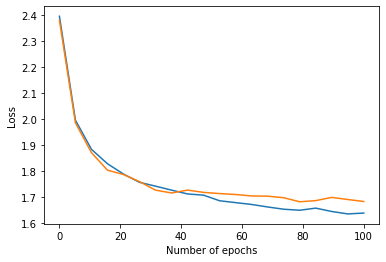

In [6]:
trainer.loss_history_plot()

In [9]:
trainer.model.eval()
gt, probs = trainer.get_probs(tag='all')

In [10]:
probs

array([[0.00097296, 0.00101708, 0.00097118, ..., 0.00097184, 0.00097122,
        0.00063557],
       [0.00097296, 0.00101708, 0.00097118, ..., 0.00097184, 0.00097122,
        0.00091244],
       [0.00097296, 0.00101708, 0.00097118, ..., 0.00097184, 0.00097122,
        0.00175641],
       ...,
       [0.00097296, 0.00101708, 0.00097118, ..., 0.00097184, 0.00097122,
        0.00189982],
       [0.00097296, 0.00101708, 0.00097118, ..., 0.00097184, 0.00097122,
        0.00119834],
       [0.00097296, 0.00101708, 0.00097118, ..., 0.00097184, 0.00097122,
        0.00257839]], dtype=float32)

In [14]:
np.where(probs[1,:]>0.2)[0]

array([ 781, 3170, 3465])

In [15]:
np.where(gt[1,:]==1)[0]

array([ 784, 2017, 2730, 2997, 3099, 3231, 3294])

In [ ]:
file_name = '04302020_resnet18_1layer_probs.npy'
save_path = f'{sys.path[0]}/weights/{file_name}'
np.save(save_path, predictions_array)

In [ ]:
from sklearn.metrics import fbeta_score

def f2score(ground_truth, probs, thre=(0.09, 0.09, 0.09, 0.09), 
          boundary=([0, 100], [100, 781], [786, 2706], [2706, 3474]),
          return_mean=True):
    predictions = np.zeros(probs.shape, dtype='int')
    f_beta = [fbeta_score(ground_truth[i,:], predictions[i,:], beta=2) for i in range(ground_truth.shape[0])]
    if return_mean:
        return sum(f_beta)/len(f_beta)
    else:
        return f_beta

In [ ]:
fb=[]
for i in range(0.05, 0.9, 0.05):
    thre = (i, i, i, i)
    fb.append(f2score(gt, probs, thre=thre))

len_ticks = len(fb)
x_axis = np.linspace(0.05, 0.9, len_ticks)
plt.figure()

plt.plot(x_axis, fb)

plt.xlabel('Number of epochs')
plt.ylabel('F2 Score')
plt.show()

In [11]:
import sys
file_name = '04302020_resnet18_1layer.model.pkl'
save_path = f'{sys.path[0]}/weights/{file_name}'
torch.save(trainer.model.state_dict(), save_path)

In [6]:
itertool = iter(trainer.dataloader_train)
img, y0, y1, y2, y3, y4 = itertool.next()

In [24]:
ground_truth = []
ground_truth += [torch.cat((y0.long().cpu(),
                                        y1.long().cpu(),
                                        F.one_hot(y2, num_classes=6).squeeze()[:, 1:].long().cpu(),
                                        y3.long().cpu(),
                                        y4.long().cpu()), dim=1)]
ground_truth += [torch.cat((y0.long().cpu(),
                                        y1.long().cpu(),
                                        F.one_hot(y2, num_classes=6).squeeze()[:, 1:].long().cpu(),
                                        y3.long().cpu(),
                                        y4.long().cpu()), dim=1)]

In [10]:
y_concat_prob = model.get_concat_probs(img.cuda())

In [13]:
predictions_tem = []
predictions_tem += [y_concat_prob.cpu()]
predictions_tem += [y_concat_prob.cpu()]

In [20]:
predictions_tem

[tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5051, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
        grad_fn=<CopyBackwards>),
 tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5051, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
        grad_fn=<CopyBackwards>)]

In [25]:
torch.cat(ground_truth).detach().numpy().shape

(64, 3474)

In [18]:
predictions_array = torch.cat(predictions_tem).detach().numpy()

In [21]:
predictions_array.shape

(64, 3474)

In [16]:
F.one_hot(y2, num_classes=6).squeeze()[:, 1:].long().cpu()


tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])

In [20]:
torch.nn.functional.one_hot(y2, num_classes=6).squeeze()[:, 1:]

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]])

In [7]:
y_pred0, y_pred1, y_pred2, y_pred3, y_pred4 = model.get_probs(img.cuda())

In [15]:
y_pred0.shape

torch.Size([16, 100])

In [20]:
torch.mean(torch.nn.functional.binary_cross_entropy(y_pred1, y1, reduction='none'), dim=1)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'target' in call to _thnn_binary_cross_entropy_forward